In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Polynomial regression - LS vs MLE with K-fold cross validation

### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

In [184]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

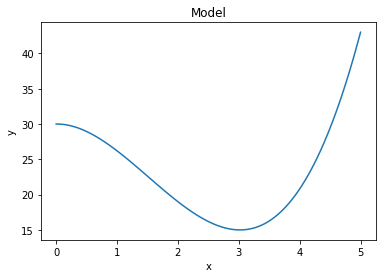

In [204]:
# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [30,0.1,-5,1.1]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=5, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

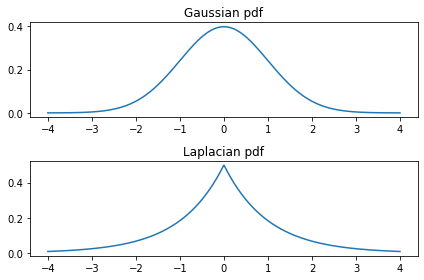

In [208]:
# Hyperparameters for the type of noise-generating distribution.
dist = "laplace"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.4   # noise magnitude
N = 200           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

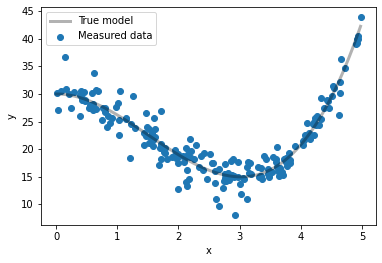

In [209]:
# Generate data points
range_start = 0
range_end = 5
u = np.sort(np.random.uniform(range_start,range_end,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

In [210]:
import scipy.optimize as optimize

def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def MLE_estimate(measured_data, input_data, model_order, num_samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = num_samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (measured_data, input_data))

    MLE_params = opt_res.x[:-1]
    #MLE_model = arbitrary_poly(MLE_params)
    
    return MLE_params

def LS_estimate(measured_data, input_data, model_order, num_samples):
    # Step 1
    # Matrix form
    u_tensor_0 = np.reshape(input_data,(num_samples,1))
    ones_vec = np.ones((num_samples,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2,model_order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, measured_data)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    #LS_model = arbitrary_poly(LS_params)
    
    return LS_params

## K-fold cross validation

In [211]:
from sklearn.model_selection import KFold, train_test_split

def cross_validate(method, X, y, model_order=2, n_splits=5):
    # Set up the K-fold splitting function and choose number of folds (5-10 is recommended)
    kf = KFold(n_splits=n_splits,shuffle=True, random_state=5)

    # RMSE will be used to evaluate the methods' performance on training, validation and test data.
    RMSE = dict()
    RMSE_train = np.array([])
    RMSE_val = np.array([])

    # K-fold slicing loop: Fit a model to k different folds of training data and validate.
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        fitted_model = method(measured_data=y_train,
                              input_data=X_train,
                              model_order=model_order,
                              num_samples=len(X_train))

        # Approximate model fitted to this fold
        sub_model = arbitrary_poly(fitted_model)

        # Calculate the avg. RMSE of the sub-model
        _RMSE_train = np.sqrt(np.mean((sub_model(X_train)-y_train)**2))
        _RMSE_val   = np.sqrt(np.mean((sub_model(X_val)-y_val)**2))

        # For increasing model order complexity, it can be beneficial to plot training vs. validation performance
        # to see when the model starts to overfit the training data.
        RMSE_train = np.append(RMSE_train, _RMSE_train)
        RMSE_val   = np.append(RMSE_val, _RMSE_val)


    # Calculate the avg & std of RMSE
    RMSE["train"] = RMSE_train
    RMSE["val"]   = RMSE_val
    #print("Average k-fold cross-validation RMSE for ", method.__name__, " with ", model_order,"-order model:", sep="")
    #print("Training data: [%.3f] +/- [%.3f]" % (RMSE_train.mean(), RMSE_train.std()))
    #print("Validation data: [%.3f] +/- [%.3f]" % (RMSE_val.mean(), RMSE_val.std()))

    return RMSE

def test_model(method, X_train, y_train, X_test, y_test, model_order):
    model_params = method(measured_data=y_train,
                          input_data=X_train,
                          model_order=model_order,
                          num_samples=len(X_train))
    
    # Fit the model using the train set and test it using the test set data    
    fitted_model = arbitrary_poly(model_params)
    RMSE_test = np.sqrt(np.mean((fitted_model(X_test)-y_test)**2))

    return RMSE_test

### Calculation loop
Here the data is split into train/validation/test sets  
and K-fold cross-validation is performed for each model order given in the order_guesses array.

In [218]:
# Split the data into training and test sets.
u_train, u_test, y_train, y_test = train_test_split(u, y, test_size=0.2, random_state=5)

# Make an educated guess for the range in which the true polynomial model lies.
min_order = 2
max_order = 8
order_guesses = np.arange(min_order, max_order+1, dtype="int")

# Select number of folds for cross-validation:
k = 5

# Containers for the different order models
MLE_train = []
MLE_val   = []
MLE_test  = []

LS_train = []
LS_val   = []
LS_test  = []

print("{}-fold Cross-Validation:".format(k))
for model_order in order_guesses:
    # Might take some time if many polynomial orders are explored, let's track the progress with a simple progress bar:
    print("\rProcessing {}th-order model (of {})".format(model_order, order_guesses[-1]), end="", flush=True)

    # Calculate the cross-valiudation results -> training and validation RMSE
    MLE_RMSE = cross_validate(MLE_estimate, u_train, y_train, model_order=model_order, n_splits=k)
    LS_RMSE = cross_validate(LS_estimate, u_train, y_train, model_order=model_order, n_splits=k)
    
    # Calculate the test-set RMSE
    MLE_RMSE_test = test_model(MLE_estimate, u_train, y_train, u_test, y_test, model_order)
    LS_RMSE_test  = test_model(LS_estimate, u_train, y_train, u_test, y_test, model_order)
    
    # Store the results
    LS_train.append(np.mean(LS_RMSE["train"]))
    LS_val.append(LS_RMSE["val"].mean())
    LS_test.append(LS_RMSE_test)
    MLE_train.append(np.mean(MLE_RMSE["train"]))
    MLE_val.append(MLE_RMSE["val"].mean())
    MLE_test.append(MLE_RMSE_test)

[2 3 4 5 6 7 8]
5-fold Cross-Validation:
Processing 8th-order model (of 8)

## Analysis of the results
K-fold Cross-validation is the prefered method for model validation (hyper parameter selection) when the available data is limited and you cannot afford to split the data into separate train/test/validate sets. K-fold cross-validation method works by creating K different splits of the data into training/validation sets, for each of these splits the training set is used to fit a sub-model, based on selected hyper parameters, and the validation set is used to evaluate it. The performance off each of the K sub-models is then averaged and returned as the cross-validation result for the model defined by the selected hyper parameters. 

In this notebook we use the K-fold cross-validation method for model order selection. The cross-validation results are given by training and validation RMSE's. Running K-fold cross validation with different model orders gives us a way of comparing their estimation accuracy, thereby making it possible for us to make a somewhat informed decision on what model order best describes the data. 

When the hyper parameters are chosen one can proceed to test the model using a test set, given that a test set is available. In this case we can generate as much data as we want, so we have a test set which we can use to evaluate the "real world performance" of our models. 

The "test error" in the figures below ("show_test_RMSE = True") shows how validation results may differ from the "real world" results. It is important to remember that "test error" should not be used for hyper parameter selection, but only as evaluation of the "real world performance" of the chosen model.

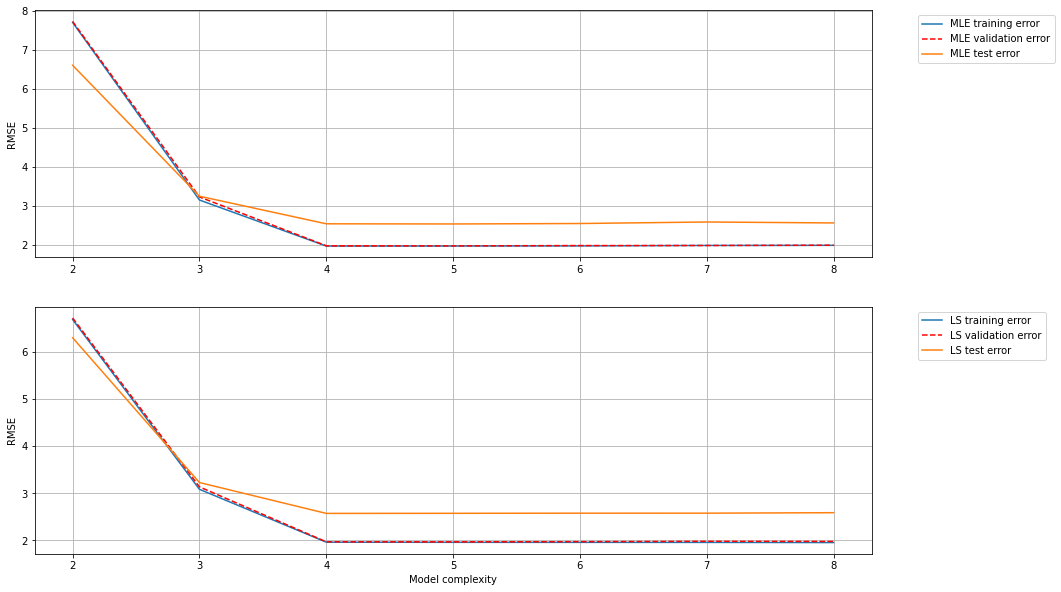

In [222]:
# Show test RMSE? (True / False)
show_test_RMSE = True

fig, (ax0, ax1) = plt.subplots(2,figsize=(15,10))
ax0.plot(order_guesses, MLE_train, label="MLE training error")
ax0.plot(order_guesses, MLE_val, 'r--', label="MLE validation error")
ax0.set_xticks(order_guesses)
ax0.set_ylabel("RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Model complexity")
ax1.plot(order_guesses, LS_train, label="LS training error")
ax1.plot(order_guesses, LS_val, 'r--', label="LS validation error")
if show_test_RMSE:
    ax0.plot(order_guesses, MLE_test, label="MLE test error")
    ax1.plot(order_guesses, LS_test, label="LS test error")
ax1.set_xticks(order_guesses)
ax0.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax1.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax0.grid()
ax1.grid()
plt.show()